# Model Interpretation for Pretrained ResNet Model

This notebook demonstrates how to apply model interpretability algorithms on pretrained ResNet model using a handpicked image and visualizes the attributions for each pixel by overlaying them on the image.

The interpretation algorithms that we use in this notebook are `Integrated Gradients` (w/ and w/o noise tunnel),  `GradientShap`, and `Occlusion`. A noise tunnel allows to smoothen the attributions after adding gaussian noise to each input sample.
  
  **Note:** Before running this tutorial, please install the torchvision, PIL, and matplotlib packages.

In [13]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

import argparse
from torchvision import models
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
import sys
import torch.nn as nn
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/src')
from dataset.celeba import CelebADataset

## 1- Loading the model and the dataset


Loads pretrained Resnet model and sets it to eval mode

In [25]:
model_seperate = models.resnet18(num_classes=2)
model_seperate.load_state_dict(torch.load('../models/celeba/seperate_more_bias_100.pt'))
model_seperate = model_seperate.eval()

model_iid = models.resnet18(num_classes=2)
model_iid.load_state_dict(torch.load('../models/celeba/iid_more_bias_100.pt'))
model_iid = model_iid.eval()

In [26]:
def get_dataset(target_column:str, protected_variable:str):
    dir = '../../data/celebA/celeba-resized'

    apply_transform_train = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5),
                                (0.5, 0.5, 0.5)),
                                ]
    )

    apply_transform_test = transforms.Compose(
        [transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5),
                                (0.5, 0.5, 0.5)),
                                ]
    )
    train_dataset = CelebADataset(dir, target_column, protected_variable, bias_level=0, transform=apply_transform_train, split='train')
    test_dataset = CelebADataset(dir, target_column, protected_variable, bias_level=0, transform=apply_transform_test, split='test')
    
    return train_dataset, test_dataset

In [27]:
_, test_dataset = get_dataset(target_column='Smiling', protected_variable='Male')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
140
Predicted: tensor([0, 1]) ( tensor([0.9089, 0.0911], grad_fn=<SqueezeBackward0>) )
Predicted: tensor([1, 0]) ( tensor([0.9260, 0.0740], grad_fn=<SqueezeBackward0>) )


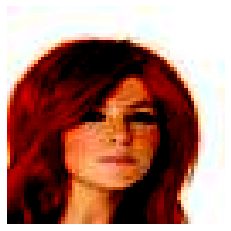

In [110]:
for index in range(110, 20000):
    input, label = test_dataset[index]
    plt.axis('off')
    output_seperate = model_seperate(input.unsqueeze(0))
    output_seperate = F.softmax(output_seperate, dim=1)
    output_iid = model_iid(input.unsqueeze(0))
    output_iid = F.softmax(output_iid, dim=1)
    _, pred1 = torch.max(output_seperate.detach(), 1)
    _, pred2 = torch.max(output_iid.detach(), 1)
    if label == pred1 and label != pred2:
        print(label)
        plt.imshow(input.permute(1,2,0))
        print(index)
        prediction_score_seperate, predicted_label_seperate = torch.topk(output_seperate, 2)
        prediction_scoreiid, predicted_label_iid = torch.topk(output_iid, 2)
        predicted_label_seperate.squeeze_()
        predicted_label_iid.squeeze_()
        print('Predicted:', predicted_label_seperate, '(', prediction_score_seperate.squeeze(), ')')
        print('Predicted:', predicted_label_iid, '(', prediction_scoreiid.squeeze(), ')')
        break

## 2- Gradient-based attribution

Let's compute attributions using Integrated Gradients and visualize them on the image. Integrated gradients computes the integral of the gradients of the output of the model for the predicted class `pred_label_idx` with respect to the input image pixels along the path from the black image to our input image.

In [117]:
model = model_iid
predicted_label = predicted_label_iid
# print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
# attributions_ig = integrated_gradients.attribute(input.unsqueeze(0), target=predicted_label, n_steps=200)
attributions_ig = integrated_gradients.attribute(input.unsqueeze(0), target=predicted_label[0], n_steps=200)

Let's visualize the image and corresponding attributions by overlaying the latter on the image.

In [118]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
# _ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
#                              np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
#                              method='heat_map',
#                              cmap=default_cmap,
#                              show_colorbar=True,
#                              sign='positive',
#                              outlier_perc=1)

Let us compute attributions using Integrated Gradients and smoothens them across multiple images generated by a <em>noise tunnel</em>. The latter adds gaussian noise with a std equals to one, 10 times (nt_samples=10) to the input. Ultimately, noise tunnel smoothens the attributions across `nt_samples` noisy samples using `smoothgrad_sq` technique. `smoothgrad_sq` represents the mean of the squared attributions across `nt_samples` samples.

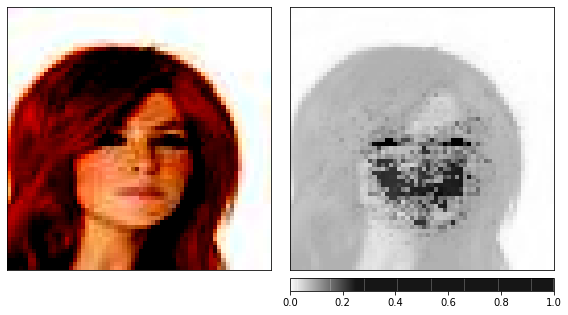

In [119]:
noise_tunnel = NoiseTunnel(integrated_gradients)

# attributions_ig_nt = noise_tunnel.attribute(input.unsqueeze(0), nt_samples=10, nt_type='smoothgrad_sq', target=predicted_label)

attributions_ig_nt = noise_tunnel.attribute(input.unsqueeze(0), nt_samples=10, nt_type='smoothgrad_sq', target=predicted_label[0])

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True,
                                      alpha_overlay=0.7
                                      )


Finally, let us use `GradientShap`, a linear explanation model which uses a distribution of reference samples (in this case two images) to explain predictions of the model. It computes the expectation of gradients for an input which was chosen randomly between the input and a baseline. The baseline is also chosen randomly from given baseline distribution.

In [39]:
# torch.manual_seed(0)
# np.random.seed(0)

# gradient_shap = GradientShap(model)

# # Defining baseline distribution of images
# rand_img_dist = torch.cat([input.unsqueeze(0) * 0, input.unsqueeze(0) * 1])

# attributions_gs = gradient_shap.attribute(input.unsqueeze(0),
#                                           n_samples=40,
#                                           stdevs=0.0001,
#                                           baselines=rand_img_dist,
#                                           target=predicted_label)
# _ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       ["original_image", "heat_map"],
#                                       ["all", "absolute_value"],
#                                       cmap=default_cmap,
#                                       show_colorbar=True)


## 3- Occlusion-based attribution

Now let us try a different approach to attribution. We can estimate which areas of the image are critical for the classifier's decision by occluding them and quantifying how the decision changes.

We run a sliding window of size 15x15 (defined via `sliding_window_shapes`) with a stride of 8 along both image dimensions (a defined via `strides`). At each location, we occlude the image with a baseline value of 0 which correspondes to a gray patch (defined via `baselines`).

**Note:** this computation might take more than one minute to complete, as the model is evaluated at every position of the sliding window.

In [88]:
# occlusion = Occlusion(model)

# attributions_occ = occlusion.attribute(input,
#                                        strides = (3, 8, 8),
#                                        target=pred_label_idx,
#                                        sliding_window_shapes=(3,15, 15),
#                                        baselines=0)


Let us visualize the attribution, focusing on the areas with positive attribution (those that are critical for the classifier's decision):

In [89]:
# _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       ["original_image", "heat_map"],
#                                       ["all", "positive"],
#                                       show_colorbar=True,
#                                       outlier_perc=2,
#                                      )


The upper part of the goose, especially the beak, seems to be the most critical for the model to predict this class.

We can verify this further by occluding the image using a larger sliding window:

In [90]:
# occlusion = Occlusion(model)

# attributions_occ = occlusion.attribute(input,
#                                        strides = (3, 50, 50),
#                                        target=pred_label_idx,
#                                        sliding_window_shapes=(3,60, 60),
#                                        baselines=0)

# _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       ["original_image", "heat_map"],
#                                       ["all", "positive"],
#                                       show_colorbar=True,
#                                       outlier_perc=2,
#                                      )